# Data Preprocessing and Cleaning

**Objective**: Clean and preprocess resume data for analysis and modeling

## Steps:
1. Load raw data
2. Handle missing values
3. Remove duplicates
4. Text cleaning and normalization
5. Outlier detection and handling
6. Data validation
7. Save processed data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Load Raw Data

In [30]:
# Load synthetic or real dataset
synthetic_path = '../data/raw/synthetic_resumes.csv'
real_path = '../data/raw/resume_dataset.csv'

# Try loading both if available
try:
    df_synthetic = pd.read_csv(synthetic_path)
    print(f"✓ Loaded synthetic data: {df_synthetic.shape}")
except FileNotFoundError:
    df_synthetic = None
    print("! Synthetic data not found")

try:
    df_real = pd.read_csv(real_path, encoding='utf-8')
    print(f"✓ Loaded real data: {df_real.shape}")
except FileNotFoundError:
    try:
        df_real = pd.read_csv(real_path, encoding='latin-1')
        print(f"✓ Loaded real data: {df_real.shape}")
    except FileNotFoundError:
        df_real = None
        print("! Real data not found")

# Combine datasets if both exist
if df_synthetic is not None and df_real is not None:
    print("\nCombining datasets...")
    # Standardize column names if needed
    df = pd.concat([df_synthetic, df_real], ignore_index=True)
    print(f"✓ Combined dataset: {df.shape}")
elif df_synthetic is not None:
    df = df_synthetic.copy()
    print(f"\nUsing synthetic data only: {df.shape}")
elif df_real is not None:
    df = df_real.copy()
    print(f"\nUsing real data only: {df.shape}")
else:
    raise FileNotFoundError("No data files found. Please generate or download data first.")

df.head()

✓ Loaded synthetic data: (500, 9)
✓ Loaded real data: (2484, 4)

Combining datasets...
✓ Combined dataset: (2984, 11)


,ID,Category,Resume,Experience_Years,Education_Level,Skills,Num_Skills,Has_Certification,Num_Companies,Resume_str,Resume_html
0,SYN_0001,Web Development,Full Stack Developer with 3 years of experienc...,3.0,Bachelor's,"Node.js, CSS, JavaScript, Redux, Vue.js, Expre...",8.0,False,1.0,NaN,NaN
1,SYN_0002,Web Development,Full Stack Developer with 9 years of experienc...,9.0,Bachelor's,"Node.js, REST APIs, MySQL, Vue.js, PostgreSQL,...",13.0,False,3.0,NaN,NaN
2,SYN_0003,Software Engineering,Software Engineer with 6 years of experience. ...,6.0,Master's,"Go, Programming, SQL, JavaScript, Algorithms, ...",11.0,False,2.0,NaN,NaN
3,SYN_0004,Web Development,Full Stack Developer with 5 years of experienc...,5.0,Master's,"Node.js, CSS, Angular, JavaScript, MySQL, Vue....",10.0,True,1.0,NaN,NaN
4,SYN_0005,Network Engineering,Network Engineer with 2 years of experience. S...,2.0,Bachelor's,"Networking, Load Balancer, TCP/IP, Security, W...",7.0,False,1.0,NaN,NaN


In [31]:
# Display basic info
print("Dataset Information:")
print("="*60)
df.info()
print("\nColumn names:", df.columns.tolist())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2984 entries, 0 to 2983
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2984 non-null   object 
 1   Category           2984 non-null   object 
 2   Resume             500 non-null    object 
 3   Experience_Years   500 non-null    float64
 4   Education_Level    500 non-null    object 
 5   Skills             500 non-null    object 
 6   Num_Skills         500 non-null    float64
 7   Has_Certification  500 non-null    object 
 8   Num_Companies      500 non-null    float64
 9   Resume_str         2484 non-null   object 
 10  Resume_html        2484 non-null   object 
dtypes: float64(3), object(8)
memory usage: 256.6+ KB

Column names: ['ID', 'Category', 'Resume', 'Experience_Years', 'Education_Level', 'Skills', 'Num_Skills', 'Has_Certification', 'Num_Companies', 'Resume_str', 'Resume_html']


## 2. Handle Missing Values

Strategy:
- Identify missing values
- Determine appropriate handling (drop, impute, or flag)
- Document decisions

Missing Values Analysis:
                              Column  Missing_Count  Missing_Percentage  \
Resume                        Resume           2484           83.243968   
Experience_Years    Experience_Years           2484           83.243968   
Education_Level      Education_Level           2484           83.243968   
Skills                        Skills           2484           83.243968   
Num_Skills                Num_Skills           2484           83.243968   
Has_Certification  Has_Certification           2484           83.243968   
Num_Companies          Num_Companies           2484           83.243968   
Resume_str                Resume_str            500           16.756032   
Resume_html              Resume_html            500           16.756032   

                  Data_Type  
Resume               object  
Experience_Years    float64  
Education_Level      object  
Skills               object  
Num_Skills          float64  
Has_Certification    object  
Num_Companies 

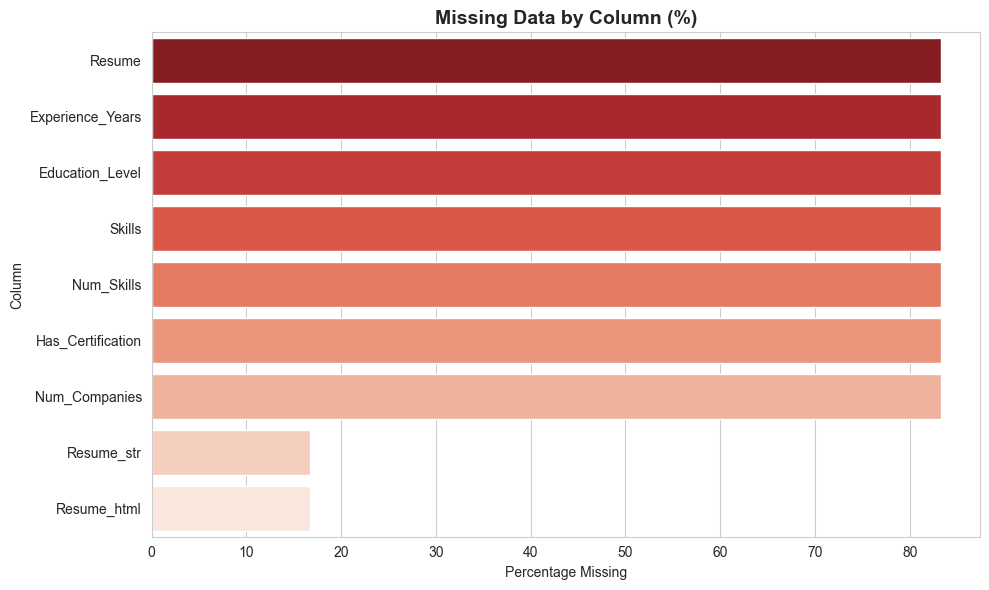

In [32]:
# Check missing values
print("Missing Values Analysis:")
print("="*60)

missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})

missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False
)

if len(missing_summary) > 0:
    print(missing_summary)
    
    # Visualize
    plt.figure(figsize=(10, 6))
    sns.barplot(data=missing_summary, y='Column', x='Missing_Percentage', palette='Reds_r')
    plt.title('Missing Data by Column (%)', fontsize=14, fontweight='bold')
    plt.xlabel('Percentage Missing')
    plt.tight_layout()
    plt.show()
else:
    print("✓ No missing values found!")

In [33]:
# Handle missing values based on column
initial_rows = len(df)

# Strategy 1: Drop rows if Resume (main text) is missing
resume_col = 'Resume' if 'Resume' in df.columns else df.columns[0]
df = df.dropna(subset=[resume_col])
print(f"Dropped {initial_rows - len(df)} rows with missing resume text")

# Strategy 2: Fill categorical missing values with 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != resume_col and df[col].isnull().sum() > 0:
        df[col].fillna('Unknown', inplace=True)
        print(f"Filled missing values in '{col}' with 'Unknown'")

# Strategy 3: Fill numerical missing values with median
numerical_cols = df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median: {median_val}")

print(f"\n✓ Missing values handled. Current shape: {df.shape}")

Dropped 2484 rows with missing resume text
Filled missing values in 'Resume_str' with 'Unknown'
Filled missing values in 'Resume_html' with 'Unknown'

✓ Missing values handled. Current shape: (500, 11)


## 3. Remove Duplicates

In [34]:
# Check for duplicates
print("Duplicate Analysis:")
print("="*60)

initial_rows = len(df)
duplicates_all = df.duplicated().sum()
duplicates_resume = df.duplicated(subset=[resume_col]).sum()

print(f"Exact duplicate rows: {duplicates_all}")
print(f"Duplicate resume text: {duplicates_resume}")

# Remove duplicates based on resume text (keep first occurrence)
df = df.drop_duplicates(subset=[resume_col], keep='first')

removed = initial_rows - len(df)
print(f"\n✓ Removed {removed} duplicate resumes")
print(f"  Current shape: {df.shape}")

Duplicate Analysis:
Exact duplicate rows: 0
Duplicate resume text: 0

✓ Removed 0 duplicate resumes
  Current shape: (500, 11)


## 4. Text Cleaning and Normalization

Clean resume text:
- Remove special characters
- Normalize whitespace
- Handle common issues
- Standardize format

In [35]:
def clean_text(text):
    """
    Clean and normalize text data.
    
    Args:
        text (str): Raw text
    
    Returns:
        str: Cleaned text
    """
    if pd.isna(text):
        return ""
    
    # Convert to string
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove phone numbers (basic patterns)
    text = re.sub(r'\+?\d[\d\s\-\(\)]{7,}\d', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    return text

# Apply cleaning
print("Cleaning resume text...")
df['Resume_Clean'] = df[resume_col].apply(clean_text)

# Calculate cleaning stats
avg_length_before = df[resume_col].str.len().mean()
avg_length_after = df['Resume_Clean'].str.len().mean()

print(f"✓ Text cleaning complete")
print(f"  Avg length before: {avg_length_before:.0f} characters")
print(f"  Avg length after: {avg_length_after:.0f} characters")
print(f"  Reduction: {((avg_length_before - avg_length_after) / avg_length_before * 100):.1f}%")

Cleaning resume text...
✓ Text cleaning complete
  Avg length before: 548 characters
  Avg length after: 543 characters
  Reduction: 1.0%


In [36]:
# Show example of cleaning
print("Example of text cleaning:")
print("="*60)
print("BEFORE:")
print(df[resume_col].iloc[0][:300])
print("\n" + "-"*60)
print("AFTER:")
print(df['Resume_Clean'].iloc[0][:300])

Example of text cleaning:
BEFORE:
Full Stack Developer with 3 years of experience. Skilled in Node.js, CSS, JavaScript, Redux, and Vue.js. Strong background in developing and deploying solutions. 

WORK EXPERIENCE:
Tech Corp (3 years) - Led development of key projects, collaborated with cross-functional teams. 

TECHNICAL SKILLS:
No

------------------------------------------------------------
AFTER:
Full Stack Developer with 3 years of experience. Skilled in Node.js, CSS, JavaScript, Redux, and Vue.js. Strong background in developing and deploying solutions. WORK EXPERIENCE: Tech Corp (3 years) - Led development of key projects, collaborated with cross-functional teams. TECHNICAL SKILLS: Node.j


In [37]:
# Add text length features (useful for analysis)
df['Resume_Length'] = df['Resume_Clean'].str.len()
df['Resume_Word_Count'] = df['Resume_Clean'].str.split().str.len()

print("Text statistics:")
print("="*60)
print(df[['Resume_Length', 'Resume_Word_Count']].describe())

Text statistics:
       Resume_Length  Resume_Word_Count
count     500.000000          500.00000
mean      542.534000           70.33800
std        93.285396           12.18428
min       397.000000           53.00000
25%       470.750000           61.00000
50%       520.000000           66.00000
75%       600.250000           78.00000
max       843.000000          105.00000


## 5. Outlier Detection and Handling

Identify outliers in:
- Resume length
- Experience years (if available)
- Number of skills (if available)

Outlier Detection:

Resume Length Outliers:
  Bounds: [276, 794]
  Outliers found: 3 (0.60%)


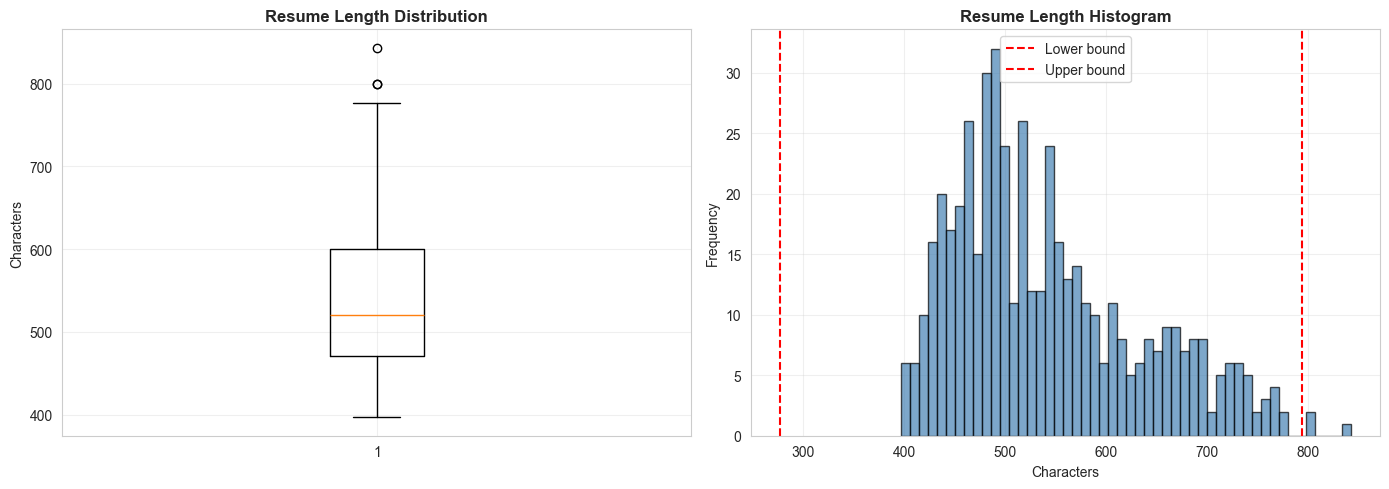

In [38]:
def detect_outliers_iqr(data, column, multiplier=1.5):
    """
    Detect outliers using IQR method.
    
    Args:
        data (pd.DataFrame): DataFrame
        column (str): Column name
        multiplier (float): IQR multiplier (default 1.5)
    
    Returns:
        pd.Series: Boolean mask of outliers
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
    
    return outliers, lower_bound, upper_bound

# Check resume length outliers
print("Outlier Detection:")
print("="*60)

outliers_length, lb_length, ub_length = detect_outliers_iqr(df, 'Resume_Length')
print(f"\nResume Length Outliers:")
print(f"  Bounds: [{lb_length:.0f}, {ub_length:.0f}]")
print(f"  Outliers found: {outliers_length.sum()} ({outliers_length.sum()/len(df)*100:.2f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
axes[0].boxplot(df['Resume_Length'])
axes[0].set_title('Resume Length Distribution', fontweight='bold')
axes[0].set_ylabel('Characters')
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(df['Resume_Length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(lb_length, color='red', linestyle='--', label='Lower bound')
axes[1].axvline(ub_length, color='red', linestyle='--', label='Upper bound')
axes[1].set_title('Resume Length Histogram', fontweight='bold')
axes[1].set_xlabel('Characters')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# Handle outliers - remove extremely short or long resumes
initial_rows = len(df)

# Keep resumes within reasonable bounds (not using IQR, but absolute thresholds)
min_length = 50  # Too short to be meaningful
max_length = df['Resume_Length'].quantile(0.99)  # Keep 99% of data

df = df[(df['Resume_Length'] >= min_length) & (df['Resume_Length'] <= max_length)]

removed = initial_rows - len(df)
print(f"\n✓ Removed {removed} outlier resumes")
print(f"  Criteria: {min_length} <= length <= {max_length:.0f}")
print(f"  Current shape: {df.shape}")


✓ Removed 5 outlier resumes
  Criteria: 50 <= length <= 770
  Current shape: (495, 14)


In [40]:
# Check for outliers in other numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
numerical_cols = [col for col in numerical_cols if col not in ['Resume_Length', 'Resume_Word_Count']]

if len(numerical_cols) > 0:
    print("\nOther Numerical Columns:")
    for col in numerical_cols:
        outliers, lb, ub = detect_outliers_iqr(df, col)
        print(f"\n{col}:")
        print(f"  Bounds: [{lb:.2f}, {ub:.2f}]")
        print(f"  Outliers: {outliers.sum()} ({outliers.sum()/len(df)*100:.2f}%)")
        
        # Flag outliers but don't remove
        df[f'{col}_is_outlier'] = outliers


Other Numerical Columns:

Experience_Years:
  Bounds: [-4.00, 12.00]
  Outliers: 0 (0.00%)

Num_Skills:
  Bounds: [2.00, 18.00]
  Outliers: 0 (0.00%)

Num_Companies:
  Bounds: [-0.50, 3.50]
  Outliers: 0 (0.00%)


## 6. Data Validation and Quality Checks

In [41]:
print("Data Quality Report:")
print("="*60)

# Check for empty text
empty_resumes = (df['Resume_Clean'].str.len() == 0).sum()
print(f"Empty resumes: {empty_resumes}")

# Check for very short resumes
short_resumes = (df['Resume_Word_Count'] < 10).sum()
print(f"Very short resumes (<10 words): {short_resumes}")

# Category distribution (if exists)
if 'Category' in df.columns:
    print(f"\nCategory distribution:")
    print(df['Category'].value_counts())
    
    # Check for rare categories
    rare_threshold = len(df) * 0.01  # Less than 1%
    rare_cats = df['Category'].value_counts()[df['Category'].value_counts() < rare_threshold]
    if len(rare_cats) > 0:
        print(f"\n⚠ Rare categories (< 1%): {rare_cats.index.tolist()}")

# Final statistics
print(f"\n{'='*60}")
print(f"Final Dataset Statistics:")
print(f"{'='*60}")
print(f"Total records: {len(df)}")
print(f"Total features: {df.shape[1]}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Data Quality Report:
Empty resumes: 0
Very short resumes (<10 words): 0

Category distribution:
Category
Machine Learning           61
Software Engineering       55
Cybersecurity              54
Database Administration    53
Web Development            52
Network Engineering        48
Data Science               47
UI/UX Design               46
Mobile Development         42
DevOps                     37
Name: count, dtype: int64

Final Dataset Statistics:
Total records: 495
Total features: 17
Missing values: 0
Duplicate rows: 0
Memory usage: 0.84 MB


## 7. Save Processed Data

In [42]:
# Save processed dataset
output_path = '../data/processed/resumes_cleaned.csv'
df.to_csv(output_path, index=False)

print(f"✓ Processed data saved to: {output_path}")
print(f"  Shape: {df.shape}")
print(f"  Columns: {df.columns.tolist()}")

# Also save a smaller summary for quick reference
summary_df = df[['Resume_Clean', 'Category' if 'Category' in df.columns else 'ID']].head(100)
summary_df.to_csv('../data/processed/resumes_sample.csv', index=False)
print(f"\n✓ Sample data saved for quick reference")

✓ Processed data saved to: ../data/processed/resumes_cleaned.csv
  Shape: (495, 17)
  Columns: ['ID', 'Category', 'Resume', 'Experience_Years', 'Education_Level', 'Skills', 'Num_Skills', 'Has_Certification', 'Num_Companies', 'Resume_str', 'Resume_html', 'Resume_Clean', 'Resume_Length', 'Resume_Word_Count', 'Experience_Years_is_outlier', 'Num_Skills_is_outlier', 'Num_Companies_is_outlier']

✓ Sample data saved for quick reference


## Summary of Data Cleaning

Document what was done:
- Missing values: [strategy]
- Duplicates: [number removed]
- Text cleaning: [methods applied]
- Outliers: [handling approach]
- Final dataset size: [shape]

In [43]:
# Create cleaning summary report
cleaning_report = {
    'final_records': len(df),
    'final_features': df.shape[1],
    'avg_resume_length': df['Resume_Length'].mean(),
    'avg_word_count': df['Resume_Word_Count'].mean(),
    'categories': df['Category'].nunique() if 'Category' in df.columns else None,
    'missing_values': df.isnull().sum().sum(),
    'date_processed': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

print("\n" + "="*60)
print("DATA CLEANING COMPLETE!")
print("="*60)
for key, value in cleaning_report.items():
    print(f"{key}: {value}")

print("\nNext step: Feature Engineering (Notebook 03)")


DATA CLEANING COMPLETE!
final_records: 495
final_features: 17
avg_resume_length: 539.9434343434343
avg_word_count: 70.02828282828283
categories: 10
missing_values: 0
date_processed: 2025-10-31 21:23:12

Next step: Feature Engineering (Notebook 03)
